# Week 11 Jupyter Notebook - Clustering Part 2 

In [1]:

import pandas as pd
import numpy as np

# Preprocessing
from sklearn.preprocessing import MinMaxScaler

# DBSCAN
from sklearn.cluster import DBSCAN

# Hierarchical Agglomerative Clustering (HAC)
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

# Metrics
from sklearn.metrics import silhouette_score

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# PCA for 2D visualization of clusters
from sklearn.decomposition import PCA


In [2]:
df = pd.read_csv('dataset_phishin.csv')
df.info(), df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11430 entries, 0 to 11429
Data columns (total 89 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   url                         11430 non-null  object 
 1   length_url                  11430 non-null  int64  
 2   length_hostname             11430 non-null  int64  
 3   ip                          11430 non-null  int64  
 4   nb_dots                     11430 non-null  int64  
 5   nb_hyphens                  11430 non-null  int64  
 6   nb_at                       11430 non-null  int64  
 7   nb_qm                       11430 non-null  int64  
 8   nb_and                      11430 non-null  int64  
 9   nb_or                       11430 non-null  int64  
 10  nb_eq                       11430 non-null  int64  
 11  nb_underscore               11430 non-null  int64  
 12  nb_tilde                    11430 non-null  int64  
 13  nb_percent                  114

(None,
                                                  url  length_url  \
 0              http://www.crestonwood.com/router.php          37   
 1  http://shadetreetechnology.com/V4/validation/a...          77   
 2  https://support-appleld.com.secureupdate.duila...         126   
 3                                 http://rgipt.ac.in          18   
 4  http://www.iracing.com/tracks/gateway-motorspo...          55   
 
    length_hostname  ip  nb_dots  nb_hyphens  nb_at  nb_qm  nb_and  nb_or  ...  \
 0               19   0        3           0      0      0       0      0  ...   
 1               23   1        1           0      0      0       0      0  ...   
 2               50   1        4           1      0      1       2      0  ...   
 3               11   0        2           0      0      0       0      0  ...   
 4               15   0        2           2      0      0       0      0  ...   
 
    domain_in_title  domain_with_copyright  whois_registered_domain  \
 0          

In [3]:
df.describe()

,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,nb_eq,...,empty_title,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank
count,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.0,11430.000000,...,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,1.143000e+04,11430.000000,11430.000000,11430.000000
mean,61.126684,21.090289,0.150569,2.480752,0.997550,0.022222,0.141207,0.162292,0.0,0.293176,...,0.124759,0.775853,0.439545,0.072878,492.532196,4062.543745,8.567566e+05,0.020122,0.533946,3.185739
std,55.297318,10.777171,0.357644,1.369686,2.087087,0.155500,0.364456,0.821337,0.0,0.998317,...,0.330460,0.417038,0.496353,0.259948,814.769415,3107.784600,1.995606e+06,0.140425,0.498868,2.536955
min,12.000000,4.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,-1.000000,-12.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,33.000000,15.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,1.000000,0.000000,0.000000,84.000000,972.250000,0.000000e+00,0.000000,0.000000,1.000000
50%,47.000000,19.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,1.000000,0.000000,0.000000,242.000000,3993.000000,1.651000e+03,0.000000,1.000000,3.000000
75%,71.000000,24.000000,0.000000,3.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,1.000000,1.000000,0.000000,449.000000,7026.750000,3.738455e+05,0.000000,1.000000,5.000000
max,1641.000000,214.000000,1.000000,24.000000,43.000000,4.000000,3.000000,19.000000,0.0,19.000000,...,1.000000,1.000000,1.000000,1.000000,29829.000000,12874.000000,1.076799e+07,1.000000,1.000000,10.000000


# Preprocessing

In [4]:
# Drop non-numeric column
df = df.drop(columns=['url'])  # 'url' is not numeric and not useful for clustering

# Encode the target variable for consistency 
df['status'] = df['status'].map({'phishing': 1, 'legitimate': 0})

# Separate features from the target 
X = df.drop(columns=['status'])  
y = df['status']  

# Step 4: Scale features 
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

print("Preprocessing complete.")
print(f"Shape of scaled data: {X_scaled.shape}")


Preprocessing complete.
Shape of scaled data: (11430, 87)


# DBSCAN

In [ ]:
# Run DBSCAN
dbscan = DBSCAN(eps=1.5, min_samples=20)  
dbscan_labels = dbscan.fit_predict(X_scaled)

# Add labels to a DataFrame for inspection
dbscan_df = pd.DataFrame(X_scaled, columns=X.columns)
dbscan_df['DBSCAN_Cluster'] = dbscan_labels

#  Print cluster counts
print(dbscan_df['DBSCAN_Cluster'].value_counts())

# Calculate silhouette score
if len(set(dbscan_labels)) > 1:
    sil_score = silhouette_score(X_scaled, dbscan_labels)
    print(f"Silhouette Score: {sil_score:.4f}")
else:
    print("Only one cluster found; silhouette score not applicable.")


DBSCAN_Cluster
 0    10767
-1      624
 1       23
 2       16
Name: count, dtype: int64
Silhouette Score: 0.1418


# DBSCAN With Core Indices

In [ ]:
from sklearn.cluster import DBSCAN

# Run DBSCAN
dbscan = DBSCAN(eps=1.5, min_samples=20)
dbscan_labels = dbscan.fit_predict(X_scaled)

# Identify core, border, and noise points
core_indices = set(dbscan.core_sample_indices_)

point_types = []
for i, label in enumerate(dbscan_labels):
    if label == -1:
        point_types.append('Noise')
    elif i in core_indices:
        point_types.append('Core')
    else:
        point_types.append('Border')

# Add point type to DataFrame
dbscan_df = pd.DataFrame(X_scaled, columns=X.columns)
dbscan_df['Cluster'] = dbscan_labels
dbscan_df['Point_Type'] = point_types

# Count types
point_type_counts = dbscan_df['Point_Type'].value_counts()
point_type_counts


Point_Type
Core      9356
Border    1450
Noise      624
Name: count, dtype: int64

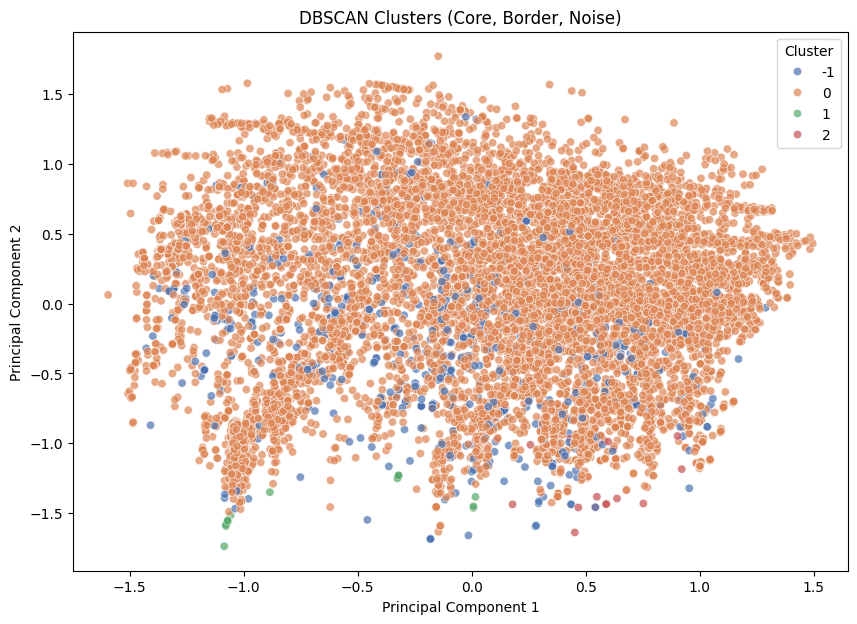

In [ ]:
# Reduce to 2D with PCA for plotting
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create DataFrame for plotting
plot_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
plot_df['Cluster'] = dbscan_labels

# Plot DBSCAN clusters
plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=plot_df, x='PC1', y='PC2',
    hue='Cluster', palette='deep', alpha=0.7,
    legend='full'
)

# Style noise points (label -1)
plt.title("DBSCAN Clusters (Core, Border, Noise)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title='Cluster')
plt.show()


# Hierarchical Agglomerative Clustering (HAC) with Linkage Methods and Dendograms

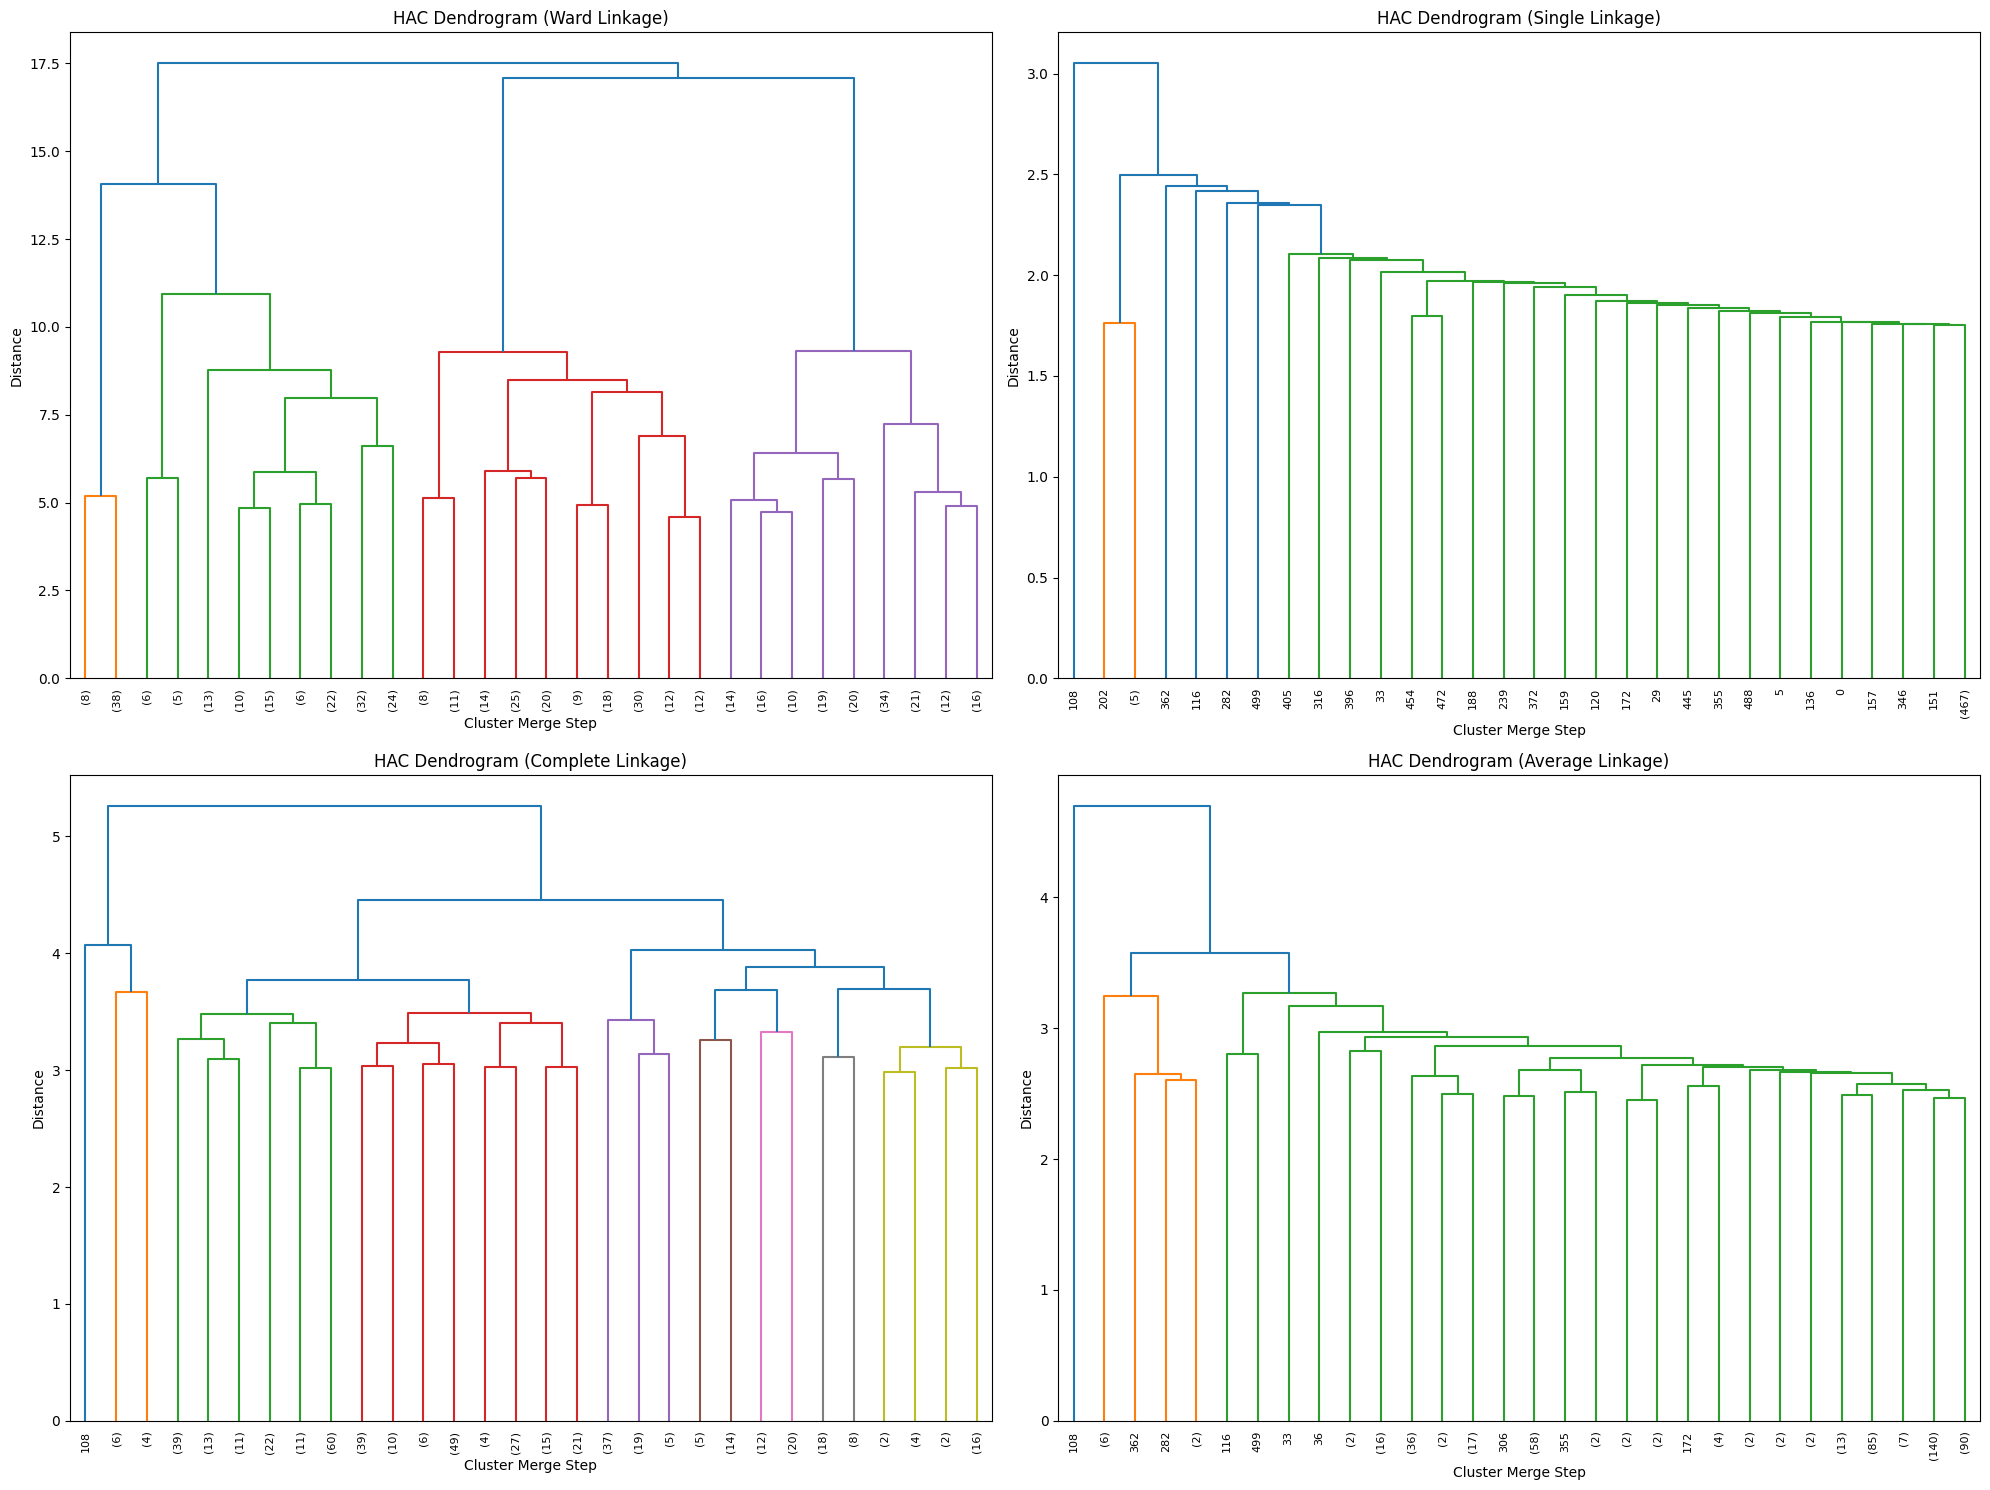

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

# Take subset of the data for visualization (500 points)
sample_data = X_scaled[:500]

# linkage methods 
linkage_methods = ['ward', 'single', 'complete', 'average']

# Plot dendrogram for each linkage method
plt.figure(figsize=(20, 15))

for i, method in enumerate(linkage_methods, 1):
    plt.subplot(2, 2, i)
    Z = linkage(sample_data, method=method)
    dendrogram(Z, truncate_mode='lastp', p=30, leaf_rotation=90., leaf_font_size=8)
    plt.title(f"HAC Dendrogram ({method.capitalize()} Linkage)")
    plt.xlabel("Cluster Merge Step")
    plt.ylabel("Distance")

plt.tight_layout()
plt.show()


For Week 11, I explored unsupervised learning by applying DBSCAN and Hierarchical Agglomerative Clustering (HAC) to the phishing dataset to uncover underlying patterns. I began with DBSCAN, which groups data points based on density and classifies each point as either a core, border, or noise point. I tuned DBSCAN’s parameters (eps=1.5, min_samples=20) to avoid overfragmented clusters, which produced three main clusters and a noise category. Cluster 0 contained the vast majority of points (10,767), while Clusters 1 and 2 were much smaller (23 and 16 points respectively), and 624 points (about 5.4% of the dataset) were labeled as noise. To gain more insight, I used DBSCAN’s core_sample_indices_ attribute to break down the cluster composition: 9,356 points (81.9%) were core points firmly embedded within clusters, 1,450 points (12.7%) were border points sitting on the edges, and the 624 noise points (5.4%) were completely unclustered. This clarified that most of the phishing and legitimate URLs fell into dense, well-defined regions, while DBSCAN still flagged meaningful outliers. I also calculated a Silhouette Score of 0.1417, which reflects some cluster overlap but is typical for noisy, high-dimensional data. For visualization, I created a PCA scatterplot showing three distinct color-coded clusters and blue noise points. I then applied HAC and produced dendrograms for Ward, Single, Complete, and Average linkage methods. The dendrograms illustrated how points merged step by step: Ward produced balanced clusters, Single showed a “chaining” effect, Complete formed compact clusters, and Average was a compromise between methods. Together, DBSCAN and HAC offered complementary insights DBSCAN isolated dense regions and labeled outliers, while HAC revealed the hierarchical structure of how URLs could group under different distance measures. This combination provided a nuanced view of the phishing dataset beyond supervised learning, giving me a clearer sense of its structure and complexity.